In [4]:
import pandas as pd
import os
from Bio import Entrez, SeqIO
import tqdm
from collections import Counter
import numpy as np
from scipy.stats import multinomial
import numpy as np
import matplotlib.pyplot as plt


In [2]:
iterator = pd.read_csv("/Users/reem/Mov/metadata_labeled.tsv", sep="\t", chunksize=1000)
metadata_df = pd.concat([chunk for chunk in tqdm.tqdm(iterator, desc='Loading data')])



Loading data: 17454it [01:30, 193.00it/s]


In [3]:
metadata_df["Virus name"] = metadata_df["Virus name"].str.split("|").str[0]

In [6]:
metadata_df.head()

,Unnamed: 0,Virus name,Last vaccinated,Passage details/history,Type,Accession ID,Collection date,Location,Additional location information,Sequence length,...,AA Substitutions,Submission date,Is reference?,Is complete?,Is high coverage?,Is low coverage?,N-Content,GC-Content,country,label
0,0,hCoV-19/Israel/SMC-7103248/2022,NaN,Original,betacoronavirus,EPI_ISL_15173403,2022-09-04,Asia / Israel,NaN,29425,...,"(NSP5_P132H,Spike_H69del,NSP1_M85del,NSP3_P679...",2022-09-29,NaN,True,NaN,True,0.192795,0.380052,Israel,True
1,1,hCoV-19/Israel/ICH-741216991/2022,NaN,Original,betacoronavirus,EPI_ISL_12375715,2022-04-09,Asia / Israel,NaN,29442,...,"(NSP5_P132H,NSP3_G489S,Spike_L24del,NSP4_T327I...",2022-04-28,NaN,True,NaN,NaN,0.031520,0.377744,Israel,True
2,2,hCoV-19/South Korea/KDCA278478/2023,NaN,Original,betacoronavirus,EPI_ISL_18712060,2023-11-28,Asia / South Korea,NaN,29752,...,"(NSP5_P132H,Spike_Q52H,NSP2_A510V,NSP12_G671S,...",2024-01-03,NaN,True,NaN,NaN,0.001916,0.378818,South Korea,True
3,3,hCoV-19/USA/CA-CDC-FG-155526/2021,NaN,Original,betacoronavirus,EPI_ISL_5901503,2021-10-23,North America / USA / California,NaN,29812,...,"(NSP3_A480V,Spike_I1114V,Spike_V1264L,N_D63G,N...",2021-11-03,NaN,True,True,NaN,0.000101,0.379617,USA,False
4,4,hCoV-19/USA/CA-CDPH-3000143864/2021,NaN,Original,betacoronavirus,EPI_ISL_5106195,2021-08-06,North America / USA / California / Contra Cost...,NaN,29874,...,"(N_G215C,N_D63G,N_R203M,NSP12_G671S,NSP16_Q238...",2021-10-13,NaN,True,NaN,NaN,0.020252,0.379664,USA,False


In [82]:
df= pd.read_csv("/Users/reem/Mov/sum_llrs.tsv", sep="\t")

In [83]:
df['seqName'] = df['seqName'].str.split("|").str[0]
df['seqName'].head()

0                 hCoV-19/USA/CA-CDPH-500004296/2021
1                     hCoV-19/Spain/CL-COV01948/2021
2                 hCoV-19/USA/OR-OHSU-213401246/2021
3              hCoV-19/Germany/SL-RKI-I-1077947/2022
4    hCoV-19/USA/MA-CDCBI-CRSP_HGQQM7RZS5PYBHGU/2022
Name: seqName, dtype: object

In [74]:
df.head()

,Unnamed: 0,seqName,LLR,G>A_llr,C>T_llr,A>G_llr,T>C_llr,sum_llrs,country,year
0,0,hCoV-19/USA/CA-CDPH-500004296/2021,0.133011,NaN,0.069622,0.004225,0.156313,0.363170,USA,2021
1,1,hCoV-19/Spain/CL-COV01948/2021,-1.049009,NaN,0.480353,0.319879,NaN,-0.248777,Spain,2021
2,2,hCoV-19/USA/OR-OHSU-213401246/2021,1.231103,NaN,-0.505227,-1.811061,-0.447496,-1.532681,USA,2021
3,3,hCoV-19/Germany/SL-RKI-I-1077947/2022,-0.210447,NaN,NaN,0.004225,NaN,-0.206223,Germany,2022
4,4,hCoV-19/USA/MA-CDCBI-CRSP_HGQQM7RZS5PYBHGU/2022,-1.073550,NaN,-0.489601,NaN,NaN,-1.563151,USA,2022


In [43]:
print(df.columns)
print(metadata_df.columns)

Index(['Unnamed: 0', 'seqName', 'LLR', 'G>A_llr', 'C>T_llr', 'A>G_llr',
       'T>C_llr', 'sum_llrs', 'country', 'year'],
      dtype='object')
Index(['Unnamed: 0', 'Virus name', 'Last vaccinated',
       'Passage details/history', 'Type', 'Accession ID', 'Collection date',
       'Location', 'Additional location information', 'Sequence length',
       'Host', 'Patient age', 'Gender', 'Clade', 'Pango lineage',
       'Pango version', 'Variant', 'AA Substitutions', 'Submission date',
       'Is reference?', 'Is complete?', 'Is high coverage?',
       'Is low coverage?', 'N-Content', 'GC-Content', 'country', 'label'],
      dtype='object')


In [6]:
merged_df = df.merge(metadata_df[['Virus name','label']], left_on='seqName', right_on='Virus name', how='inner')

merged_df.head()

,Unnamed: 0,seqName,LLR,G>A_llr,C>T_llr,A>G_llr,T>C_llr,sum_llrs,country,year,Virus name,label
0,0,hCoV-19/USA/CA-CDPH-500004296/2021,0.133011,NaN,0.069622,0.004225,0.156313,0.363170,USA,2021,hCoV-19/USA/CA-CDPH-500004296/2021,False
1,1,hCoV-19/Spain/CL-COV01948/2021,-1.049009,NaN,0.480353,0.319879,NaN,-0.248777,Spain,2021,hCoV-19/Spain/CL-COV01948/2021,False
2,2,hCoV-19/USA/OR-OHSU-213401246/2021,1.231103,NaN,-0.505227,-1.811061,-0.447496,-1.532681,USA,2021,hCoV-19/USA/OR-OHSU-213401246/2021,False
3,3,hCoV-19/Germany/SL-RKI-I-1077947/2022,-0.210447,NaN,NaN,0.004225,NaN,-0.206223,Germany,2022,hCoV-19/Germany/SL-RKI-I-1077947/2022,True
4,4,hCoV-19/USA/MA-CDCBI-CRSP_HGQQM7RZS5PYBHGU/2022,-1.073550,NaN,-0.489601,NaN,NaN,-1.563151,USA,2022,hCoV-19/USA/MA-CDCBI-CRSP_HGQQM7RZS5PYBHGU/2022,True


In [7]:
merged_df.to_csv("/Users/reem/Mov/merged_df.tsv",sep="\t")

In [20]:
df['sum_llrs']=df[['LLR','G>A_llr','A>G_llr','C>T_llr','T>C_llr']].sum(axis=1,skipna=True)
#df['sum_llrs'].head()


print(df['sum_llrs'].min())
print(df['sum_llrs'].max())
print(df['sum_llrs'].mean())
print(df['sum_llrs'].describe())


-6287.242208775208
53.621186859056515
-1.3153611359911954
count    1.685715e+07
mean    -1.315361e+00
std      7.441284e+00
min     -6.287242e+03
25%     -2.290032e+00
50%     -7.957429e-01
75%      1.331973e-01
max      5.362119e+01
Name: sum_llrs, dtype: float64


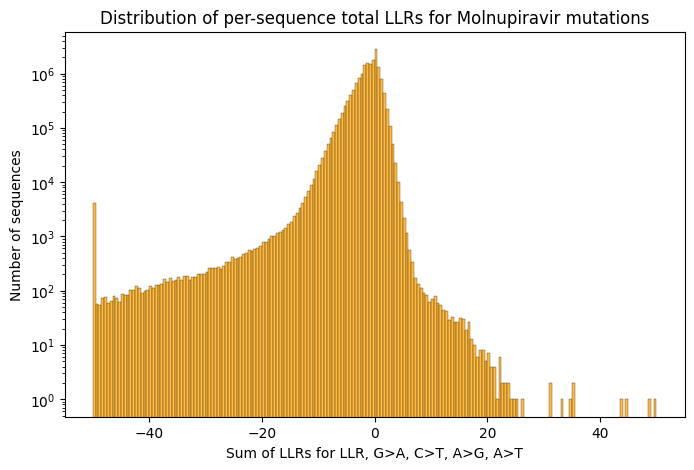

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.histplot(df["sum_llrs"].clip(-50,50), bins=200, color='orange')
#plt.xlim(-30, 60)
plt.yscale('log')
plt.title("Distribution of per-sequence total LLRs for Molnupiravir mutations")
plt.xlabel("Sum of LLRs for LLR, G>A, C>T, A>G, T>C")
plt.ylabel("Number of sequences")
plt.show()

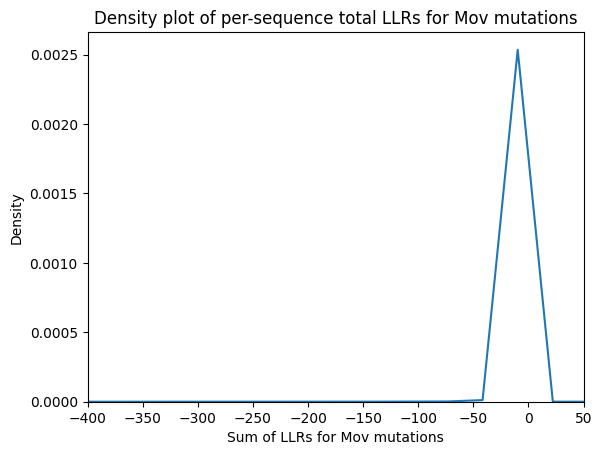

In [27]:
sns.kdeplot(df["sum_llrs"], bw_adjust=0.5)
plt.xlim(-400, 50)
plt.xlabel("Sum of LLRs for Mov mutations")
plt.title("Density plot of per-sequence total LLRs for Mov mutations")
plt.show()

In [28]:
len(df)

16857152

In [30]:
len(df[df['sum_llrs']>0])

4749036

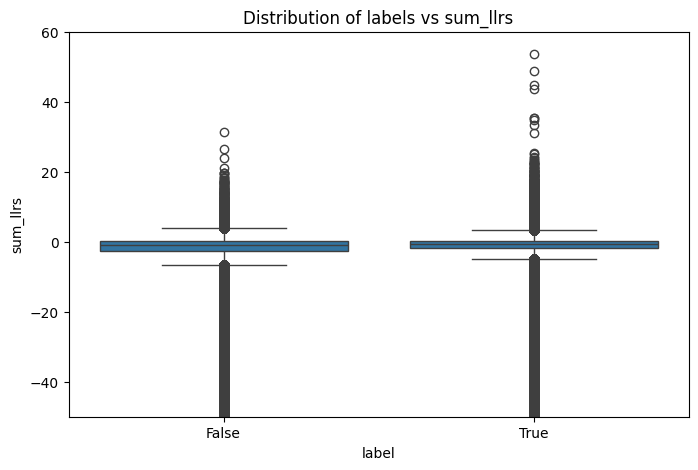

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x = 'label', y ='sum_llrs')
plt.title('Distribution of labels vs sum_llrs')
plt.ylim(-50, 60)

plt.show()

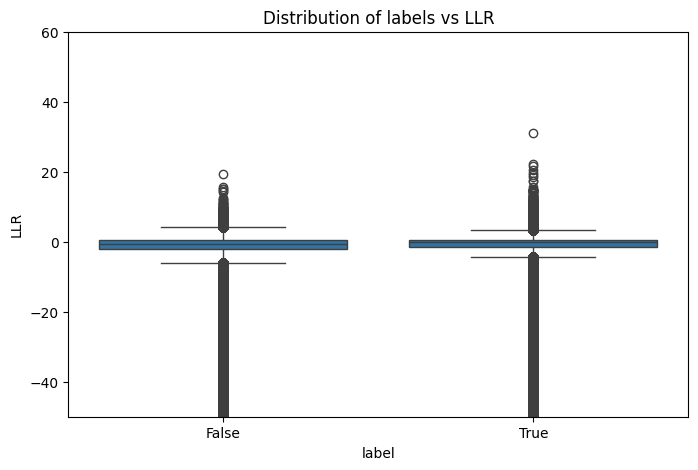

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x = 'label', y ='LLR')
plt.title('Distribution of labels vs LLR')
plt.ylim(-50, 60)

plt.show()

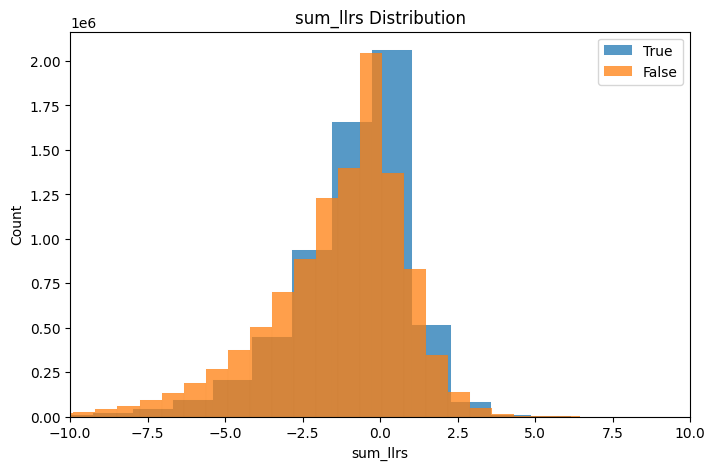

In [95]:
plt.figure(figsize=(8,5))
sns.histplot(data=merged_df[merged_df['label']==True],x='sum_llrs',label='True',fill=True)
sns.histplot(data=merged_df[merged_df['label']==False],x='sum_llrs',label='False',fill=True)
plt.title('sum_llrs Distribution')
plt.xlim(-10,10)
plt.legend()
plt.show()

In [84]:

df['country'] = df['seqName'].str.split("/").str[1]
df['year'] = df['seqName'].str.split("/").str[3]
df = df[['seqName','LLR','G>A_llr','C>T_llr','A>G_llr','T>C_llr','sum_llrs','country', 'year',]]
#df.to_csv("molnupiravir_positive_llrs.tsv", sep="\t", index=False)

# print(df['country'].value_counts())
# print(df['year'].value_counts())



In [42]:
thresholds = [2,5,6,7,8,10,15,20]
countries = ['Australia','France']
for t in thresholds:
    for country in countries:
        count = len(df[(df['sum_llrs'] > t) & (df['seqName'].str.contains(f"/{country}/"))])
        print(f"Number of sequences from {country} with sum_llrs > {t}: {count}")

             

Number of sequences from Australia with sum_llrs > 2: 6620
Number of sequences from France with sum_llrs > 2: 14402
Number of sequences from Australia with sum_llrs > 5: 689
Number of sequences from France with sum_llrs > 5: 142
Number of sequences from Australia with sum_llrs > 6: 538
Number of sequences from France with sum_llrs > 6: 30
Number of sequences from Australia with sum_llrs > 7: 430
Number of sequences from France with sum_llrs > 7: 6
Number of sequences from Australia with sum_llrs > 8: 358
Number of sequences from France with sum_llrs > 8: 3
Number of sequences from Australia with sum_llrs > 10: 243
Number of sequences from France with sum_llrs > 10: 0
Number of sequences from Australia with sum_llrs > 15: 77
Number of sequences from France with sum_llrs > 15: 0
Number of sequences from Australia with sum_llrs > 20: 21
Number of sequences from France with sum_llrs > 20: 0


In [ ]:
thresholds = [2,5,6,7,8,10,15,20]
for t in thresholds:
    
    for country in countries:
        count = len(df[(df['sum_llrs'] > t) & (df['seqName'].str.contains(f"/{country}/"))])
        print(f"Number of sequences from {country} with sum_llrs > {t}: {count}")


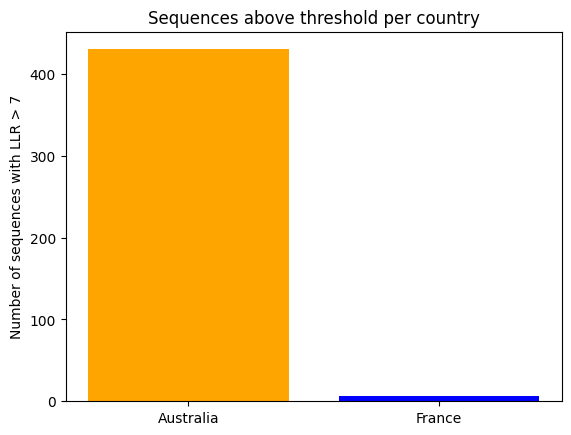

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define threshold
t = 7

# Count sequences above threshold for each country
countries = ['Australia', 'France']
counts = [
    (df[df['country']=='Australia']['sum_llrs'] > t).sum(),
    (df[df['country']=='France']['sum_llrs'] > t).sum()
]

# Create bar plot
plt.bar(countries, counts, color=['orange', 'blue'])
plt.ylabel("Number of sequences with LLR > {}".format(t))
plt.title("Sequences above threshold per country")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

thresholds = range(2, 20, 1)
australia_counts = [(df[df['country']=='Australia']['sum_llrs'] > t).sum() for t in thresholds]
france_counts = [(df[df['country']=='France']['sum_llrs'] > t).sum() for t in thresholds]



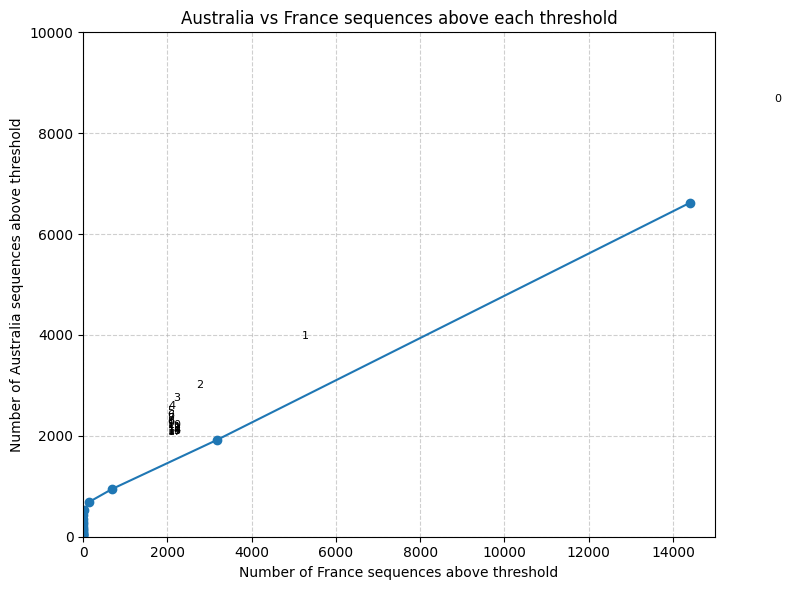

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(france_counts, australia_counts, 'o-', color='C0')

for i, (x, y) in enumerate(zip(france_counts, australia_counts)):
    plt.text(x + 2000, y + 2000, i, fontsize=8)  # label thresholds
   
plt.xlabel("Number of France sequences above threshold")
plt.ylabel("Number of Australia sequences above threshold")
plt.title("Australia vs France sequences above each threshold")


plt.xlim(0,15000)
plt.ylim(0,10000)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [36]:
df.to_csv("/Users/reem/Mov/sum_llrs.tsv",sep="\t")

In [93]:
df.head()
df.to_csv("/Users/reem/Mov/sum_llrs_country.tsv", sep="\t")
